<a href="https://colab.research.google.com/github/KKawaguchi1219/Frog-Oscillator/blob/main/FrogOscillator_FreqClassification_KLdiv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目標(方針，4/25時点)：
*   カエル間の種の識別を鳴き声の周波数の分布で区別させる
    *   シュレーゲルアオガエル：約 $2$ kHz
    *   二ホンアマガエル：約 $3.5$ kHz
    *   まずは正規分布

*   2クラスター同期状態が破綻するのを判断する指標を作る

相互作用の強さ：

$
\begin{align}
    K_{mn} &= \frac{k}{c_{KL}D_{KL}(f_m,\ f_n)+c}, \quad D_{KL}:\rm{Kullback–Leibler \ divergence}\\
    r_{mn} &= r_m-r_n, \\
    k, c, c_{KL} &= \mathrm{const.}
\end{align}
$

ダイナミクス

$
\begin{align}
    \frac{\mathrm{d} }{\mathrm{d}t}\theta_i &=\omega_n + \sum_{m\ne n} -\frac{K_{mn}}{r_{mn}^2} \sin(\theta_m-\theta_n) \\
    \frac{\mathrm{d} }{\mathrm{d}t}\mathbb{r}_i &= \sum_{m\ne n} -\frac{K_{mn}}{r_{mn}^2} [1-\cos(\theta_m-\theta_n)\mathbb{e}_{mn}] + (L-|r_n|)\mathbb{e}_{n} \\
\end{align}
$

frog1:シュレーゲルアオガエル \
frog2:二ホンアマガエル

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
def Γ_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    return -K_mn/(np.linalg.norm(r_m-r_n)**2)*np.sin(θ_m-θ_n)

In [ ]:
def F_mn(r_m, r_n, θ_m, θ_n, K_mn=1):
    r_mn = r_m-r_n
    e_mn = r_mn/np.linalg.norm(r_mn)
    return -K_mn/(np.linalg.norm(r_mn)**2)*(1-np.cos(θ_m-θ_n))*e_mn

In [ ]:
def G_n(r_n, L):
    e_n = r_n/np.linalg.norm(r_n)
    return (L-np.linalg.norm(r_n))*e_n

In [ ]:
def KLdiv_norm(µ1, µ2):
    return (µ1-µ2)**2/2

In [ ]:
def Kmn_calc(µ_m, µ_n, r_m, r_n, c=1, k=1, c_kl=1e-4):
    return k/(c_kl*KLdiv_norm(µ_m, µ_n)+c)

In [ ]:
def frog_oscillator_KLdivFreq(t, state, N, L, omega, µ, c_kl, freqs):

    theta, x, y = state[:N], state[N:2*N], state[2*N:]
    r = np.stack([x, y], axis=1)
    # frogs = ['A' if i < N // 2 else 'B' for i in range(N)]
    # freqs = np.array([µ[0] if i < N // 2 else µ[1] for i in range(N)])

    dtheta = np.full(N, omega)

    dr = np.zeros((N, 2))
    dx = np.zeros(N)
    dy = np.zeros(N)

    for i in range(N):
        for j in range(N):
            # i<N//2 : カエルA，i>=N//2 : カエルB

            if i == j: continue

            K_mn = Kmn_calc(freqs[i], freqs[j], r[i], r[j], c_kl=c_kl)

            # phase
            dtheta[i] += Γ_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)

            # location
            dr[i] += F_mn(r[j], r[i], theta[j], theta[i], K_mn=K_mn)
            # dr[i] += F_mn(r[j], r[i], theta[j], theta[i])

        dr[i] += G_n(r[i], L)

        dx[i] = dr[i, 0]
        dy[i] = dr[i, 1]

    return np.concatenate([dtheta, dx, dy])


In [ ]:
N = 12              # カエルの個体数
L = 20              # 円の半径
omega = 4*2*np.pi   #角速度

µ = np.array([2e3, 3.5e3])                                          # 鳴き声の周波数(正規分布)の平均
freqs = np.array([µ[0] if i < N // 2 else µ[1] for i in range(N)])  # 各カエルへの周波数の割り当て
c_kl = 1e-4                                                         # 相互作用の強さ

# カエルの初期配置
x = np.random.uniform(-L+5, L+5, N)
y = np.random.uniform(-L+5, L+5, N)

# 初期位相（ランダム設定）
theta1_init = np.random.normal(np.pi, 0.5, N//2)
theta2_init = np.random.normal(np.pi, 0.5, N//2)

# 初期状態まとめ
state_init = np.concatenate([theta1_init, theta2_init, x, y])

t_max=50000
dt=1
t_span = (0, t_max)  # 時間範囲
t_eval = np.arange(t_span[0], t_span[1], dt)  # 出力時間

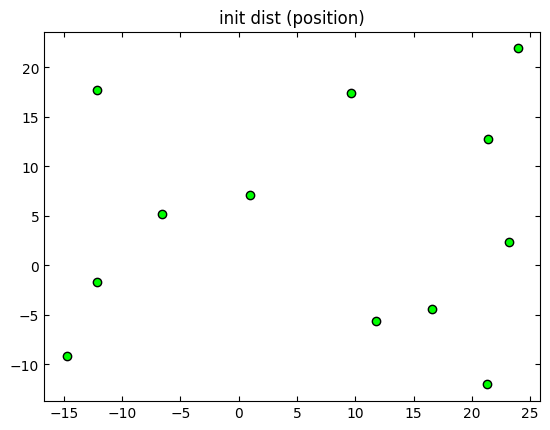

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_title('init dist (position)')

r=np.stack([x, y], axis=1)
ax.scatter(r[:, 0], r[:, 1], c='lime', ec='k')
plt.show()

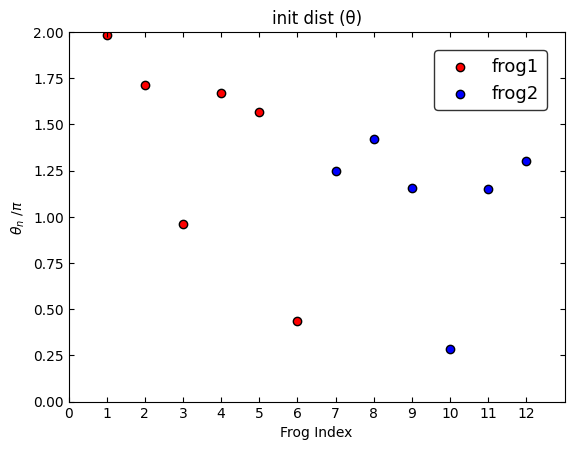

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(0, N+1)
ax.set_ylim(0, 2)
ax.set_xlabel("Frog Index")
ax.set_ylabel(r'$\theta_n\ /\pi$')
ax.set_xticks(np.arange(N+1))
ax.set_title('init dist (θ)')

ax.scatter(np.arange(N//2)+1, (theta1_init % 2*np.pi)/np.pi, c='r', ec='k', label='frog1')
ax.scatter(np.arange(N//2, N)+1, (theta2_init % 2*np.pi)/np.pi, c='b', ec='k', label='frog2')
ax.legend(edgecolor='k', fontsize=13, borderaxespad=1)
plt.show()

In [ ]:
solution = solve_ivp(
    fun=frog_oscillator_KLdivFreq,
    args=(N, L, omega, µ, c_kl, freqs),
    t_span=t_span,
    y0=state_init,
    t_eval=t_eval,
    method='RK45'
)

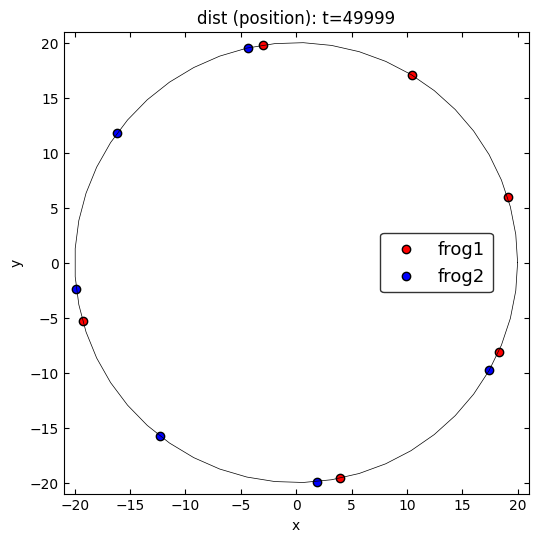

In [ ]:
time=int(len(solution.t)-1)

anystep_data = solution.y[:, time]
x_anystep = anystep_data[N:2*N]
y_anystep = anystep_data[2*N:]

fig, ax=plt.subplots(figsize=(6, 6))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlim(-L-1, L+1)
ax.set_ylim(-L-1, L+1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"dist (position): t={time}")

ax.plot(L*np.cos(np.linspace(0, 2*np.pi)), L*np.sin(np.linspace(0, 2*np.pi)), lw=0.5, c='k')

ax.scatter(x_anystep[:N//2], y_anystep[:N//2], c='r', ec='k', label='frog1')
ax.scatter(x_anystep[N//2:N], y_anystep[N//2:N], c='b', ec='k', label='frog2')
ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)

plt.show()

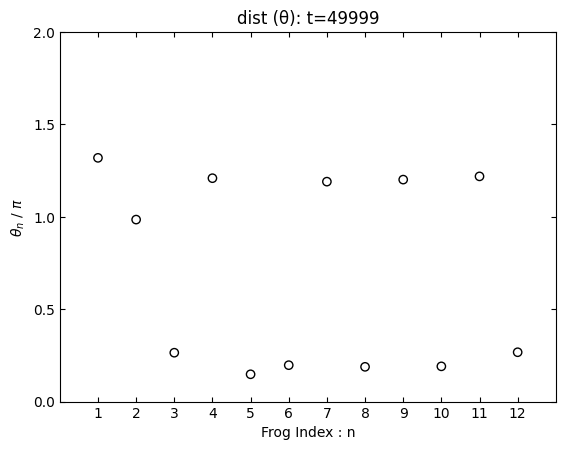

In [ ]:
fig, ax = plt.subplots()

n=np.arange(N)+1

ax.set_ylim(0, 2)
ax.set_xlim(0, N+1)
ax.set_xticks(n)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Frog Index : n")
ax.set_ylabel(r"$\theta_n \ /\ \pi$")
ax.set_title(f"dist (θ): t={time}")

anystep_data = solution.y[:, time]
θ_anystep = anystep_data[:N]

angle_equ_frog = np.atan2(y_anystep, x_anystep)
sort_indices = np.argsort(angle_equ_frog)
θ_anystep_sorted = θ_anystep[sort_indices]

ax.scatter(n, (θ_anystep_sorted % (2*np.pi))/np.pi, c='None', ec='k')

plt.show()

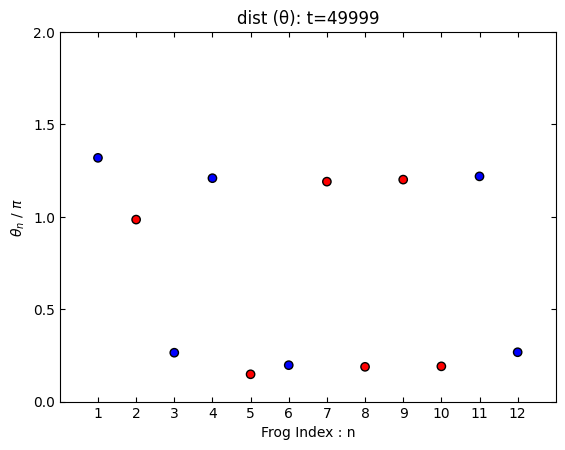

In [ ]:
fig, ax = plt.subplots()

n=np.arange(N)+1

ax.set_ylim(0, 2)
ax.set_xlim(0, N+1)
ax.set_xticks(n)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Frog Index : n")
ax.set_ylabel(r"$\theta_n \ /\ \pi$")
ax.set_title(f"dist (θ): t={time}")

# 任意の時刻での位相データ
anystep_data = solution.y[:, time]
θ_anystep = anystep_data[:N]

# 空間的な角度を元に，位相をソート
angle_equ_frog = np.atan2(y_anystep, x_anystep)
sort_indices = np.argsort(angle_equ_frog)
θ_anystep_sorted = θ_anystep[sort_indices]

# 色分け
colors = np.array(['red' if i < N // 2 else 'blue' for i in range(N)])
color_sorted = colors[sort_indices]

ax.scatter(n, (θ_anystep_sorted % (2*np.pi))/np.pi, c=color_sorted, ec='k')

plt.show()

order parameter

In [ ]:
# 周波数が同じ種間のR_{cluster}とR_{in}を計算

R_cluster_frog1, R_cluster_frog2, R_in_frog1, R_in_frog2 = [], [], [], []

for i_step_data in solution.y.T:
    θ_equ = i_step_data[:N]
    frog1_θ, frog2_θ = θ_equ[:N//2], θ_equ[N//2:]

    R_cluster_frog1.append(np.abs(np.mean(np.exp(1j * 2 * frog1_θ))))
    R_cluster_frog2.append(np.abs(np.mean(np.exp(1j * 2 * frog2_θ))))
    R_in_frog1.append(np.abs(np.mean(np.exp(1j * frog1_θ))))
    R_in_frog2.append(np.abs(np.mean(np.exp(1j * frog2_θ))))

In [ ]:
# 全てのカエルのR_{cluster}とR_{in}を計算

R_cluster, R_in = [], []

for i_step_data in solution.y.T:
    θ_equ = i_step_data[:N]
    R_cluster.append(np.abs(np.mean(np.exp(1j * 2 * θ_equ))))
    R_in.append(np.abs(np.mean(np.exp(1j * θ_equ))))

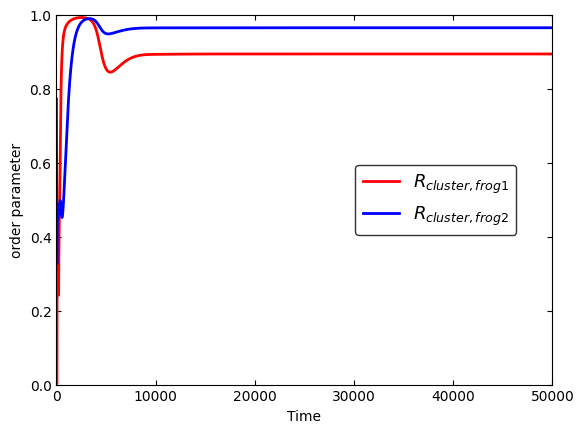

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_cluster_frog1, c='r', lw=2, label=r'$R_{cluster, frog1}$')
ax.plot(solution.t, R_cluster_frog2, c='b', lw=2, label=r'$R_{cluster, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

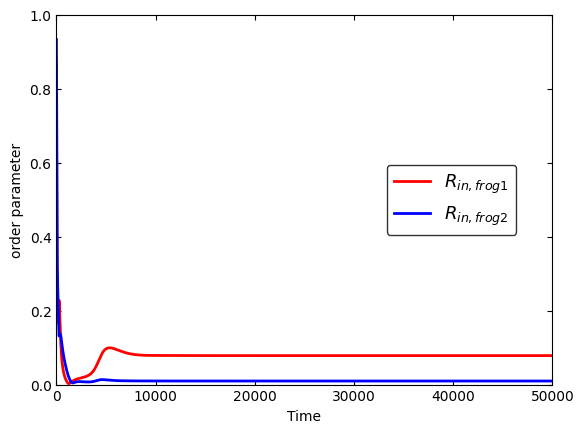

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_in_frog1, c='r', lw=2, label=r'$R_{in, frog1}$')
ax.plot(solution.t, R_in_frog2, c='b', lw=2, label=r'$R_{in, frog2}$')

ax.legend(loc='center right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

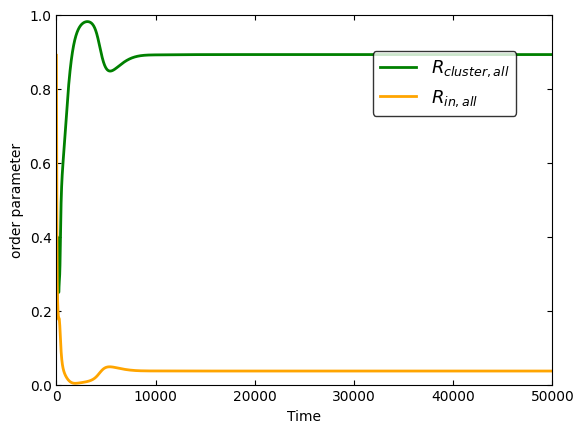

In [ ]:
fig, ax = plt.subplots()
n=np.arange(1, N+1)
ax.set_ylim(0, 1)
ax.set_xlim(0, t_max)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("Time")
ax.set_ylabel('order parameter')

ax.plot(solution.t, R_cluster, c='g', lw=2, label=r'$R_{cluster, all}$')
ax.plot(solution.t, R_in, c='orange', lw=2, label=r'$R_{in, all}$')

ax.legend(loc='upper right', edgecolor='k', fontsize=13, borderaxespad=2)
plt.show()

test

In [ ]:
def merge(frog1, frog2):
    result = []  # 結果を格納するリスト
    i, j = 0, 0

    while i < len(frog1) and j < len(frog2):
        if frog1[i] <= frog2[j]:
            result.append((frog1[i], "frog1"))  # frog1 から追加
            i += 1
        else:
            result.append((frog2[j], "frog2"))  # frog2 から追加
            j += 1

    # 残りの要素を追加
    result.extend((x, "frog1") for x in frog1[i:])
    result.extend((x, "frog2") for x in frog2[j:])

    return result

In [ ]:
hoge1=[1,2,5]
hoge2=[3,4,6]
ls_test = merge(hoge1, hoge2)
ls_test

[(1, 'frog1'),
 (2, 'frog1'),
 (3, 'frog2'),
 (4, 'frog2'),
 (5, 'frog1'),
 (6, 'frog2')]

In [ ]:
color_lis=[]
for frog in ls_test:
    if frog[1]=='frog1':
        color_lis.append('red')
    else:
        color_lis.append('blue')

color_lis

['red', 'red', 'blue', 'blue', 'red', 'blue']